In [1]:
from wand.image import Image, Color
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
def pdf2jpg(filepath, savepath):
    
    with Image(filename = filepath, resolution = 300) as img:
        
        img.background_color = Color("White")
        img.alpha_channel = 'remove'
        img.save(filename = save_path)

In [3]:
def read(path):
    
    img_dim = (500,500)
    original = mpimg.imread(path)
    resized = cv2.resize(original, img_dim)
    print("Image shape:", resized.shape)
    if len(resized.shape) == 2:
        img = cv2.cvtColor(resized, cv2.COLOR_GRAY2RGB)
    else:
        img = resized
    
    return img

In [4]:
def im_process(img):
    
    low_thresh = 210
    upper_thresh = 255
    blur_kernel = (5,5)
    stddev = 0
    canny_minval = 150
    canny_maxval = 220
    nbd_size = 2
    sobel_kernel = 5
    harris_parameter = 0.07
    
    ret, binary = cv2.threshold(img, low_thresh, upper_thresh, cv2.THRESH_BINARY)
    binary = np.uint8(binary)
    blur = cv2.GaussianBlur(binary, blur_kernel, stddev)
    edges = cv2.Canny(np.uint8(np.copy(blur)), canny_minval, canny_maxval)
    gray = cv2.cvtColor(blur, cv2.COLOR_RGB2GRAY)
    corners = cv2.cornerHarris(np.copy(np.uint8(gray)), nbd_size, sobel_kernel, harris_parameter)
    sobelx = cv2.Sobel(corners,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(corners,cv2.CV_64F,0,1,ksize=5)
    
    return corners, sobelx, sobely

In [5]:
def find_direction(sobelx, sobely):
    
    tan_inverse = (np.arctan2(sobely,sobelx))
    angle = np.sum(tan_inverse)/tan_inverse.size
    
    return angle

In [6]:
def rotate(img, angle):
    
    theta = ((angle - (np.pi)/4) * 180) / np.pi
    rotated = imutils.rotate(img, theta)
    
    return rotated

In [7]:
def find_localminima(histogram):
    
    return (np.r_[True, histogram[1:] < histogram[:-1]] & np.r_[histogram[:-1] < histogram[1:], True])

In [8]:
def find_endpoints(boolean):
    
    flag1 = 0
    false_thresh = 40

    for truth in range(len(boolean)):
    
        if (boolean[truth]) & (flag1 == 0): 
            dim1 = truth
            flag1 = 1
            prev_truth = 0
            remaining = len(boolean) - dim1
        if flag1:
            for next_truth in range(remaining):
                index = dim1 + next_truth
                if boolean[index]:
                    dim2 = index
                    prev_truth = 0
                prev_truth += 1
                if prev_truth > false_thresh:
                    break
                
    return dim1, dim2

In [9]:
def crop_img(img, w1, w2, h1, h2):
    
    return(img[w1:w2, h1:h2])

In [10]:
def mask(identity, watermark):
    
    watermark = np.dstack([watermark, np.ones((watermark.shape[0], watermark.shape[1]), dtype="uint8") * 255])
    identity = np.dstack([identity, np.ones((identity.shape[0], identity.shape[1]), dtype="uint8") * 255])
    return (cv2.addWeighted(identity, 0.8, watermark, 0.2, 0))

Image shape: (500, 500, 3)


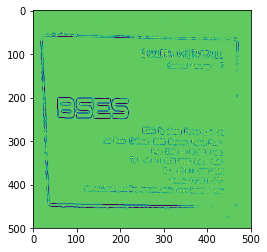

In [29]:
img = read('BSES/business_card.jpg')
corners, sobelx, sobely = im_process(img)
plt.imshow(corners)

In [30]:
# Find orientation

theta = find_direction(sobelx, sobely)
print("Theta:", theta)

if theta > 0.07 or theta < -0.07:

    rotated = rotate(corners, 0.2*theta)
    corners = rotated
    rotated_img = rotate(img, 0.2*theta)
    img = rotated_img
    plt.imshow(rotated)

Theta: 0.0136142940546


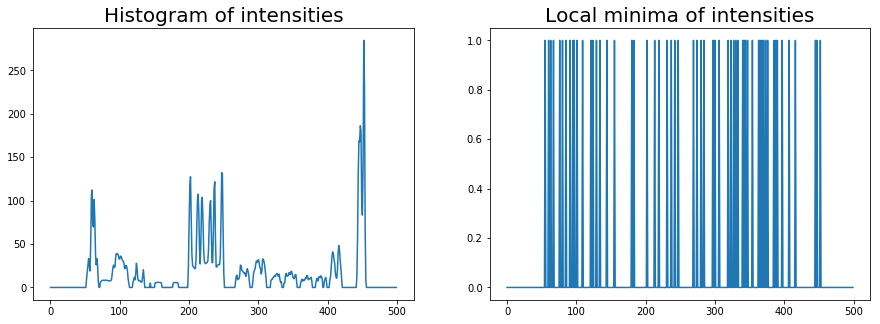

In [31]:
# Finding approximate width of the id

histogram_w = np.sum(corners, axis = 1)
histogram_w[histogram_w > -5] = 0
boolean_w = find_localminima(histogram_w)
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
ax1.plot(histogram_w * -1)
ax1.set_title('Histogram of intensities', fontsize = 20)
ax2.plot(boolean_w)
ax2.set_title('Local minima of intensities', fontsize = 20)
plt.show()

In [32]:
w1, w2 = find_endpoints(boolean_w)
print("Width:", (w2-w1), "pixels")

Width: 397 pixels


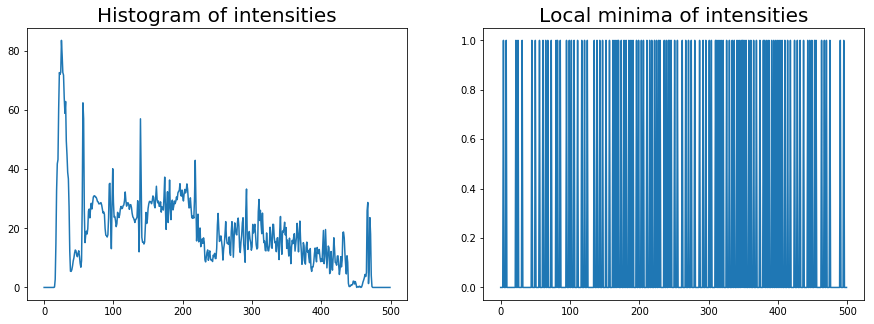

In [33]:
# Finding approximate height of the id

histogram_h = np.sum(corners, axis = 0)
histogram_h[histogram_h > -1e-3] = 0
boolean_h = find_localminima(histogram_h)
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
ax1.plot(histogram_h * -1)
ax1.set_title('Histogram of intensities', fontsize = 20)
ax2.plot(boolean_h)
ax2.set_title('Local minima of intensities', fontsize = 20)
plt.show()

In [34]:
h1, h2 = find_endpoints(boolean_h)
print("Height:", (h2-h1),"pixels")

Height: 491 pixels


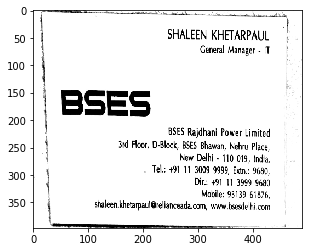

In [35]:
cropped = crop_img(img, w1, w2, h1, h2)
plt.imshow(cropped)

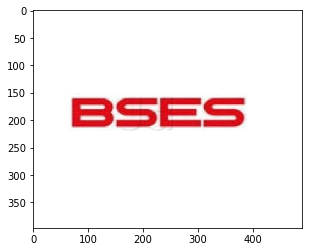

In [36]:
# Read watermark

logo = mpimg.imread('BSES/bses-rajdhani-power-limited-head-office-nehru-place-delhi-electricity-supply-40j7aym.jpg')
resized_logo = cv2.resize(logo, (h2 - h1, w2 - w1))
plt.imshow(resized_logo)

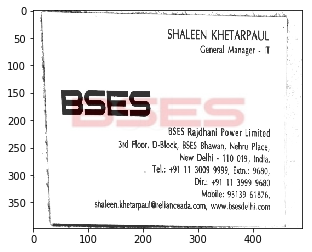

In [37]:
final = mask(cropped, resized_logo)
plt.imshow(final)